# Analysis of Yelp Business Intelligence Data

We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) although we have taken steps to pull this data into a publis s3 bucket: `s3://sta9760-yelpdataset/yelp-light/*business.json`

# Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install `pandas` and `matplotlib`

In [1]:
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("seaborn==0.10.0")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,application_1588447639270_0004,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)
  Using cached kiwisolver-1.2.0-cp36-cp36m-manylinux1_x86_64.whl (88 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)

  Using cached pandas-1.0.3-cp36-cp36m-manylinux1_x86_64.whl (10.0 MB)

  Using cached seaborn-0.10.0-py3-none-any.whl (215 kB)
  Using cached scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl (26.1 MB)

## Importing

Now, import the installed packages from the previous block below.

In [26]:
import matplotlib
import pandas
import seaborn

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data

We are finally ready to load data. Using `spark` load the data from S3 into a `dataframe` object that we can manipulate further down in our analysis.

In [3]:
df1 = spark.read.json('s3://yelp-dataset-jack/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Overview of Data

Display the number of rows and columns in our dataset.

In [4]:
print(f'Columns: {len(df1.dtypes)} | Rows: {df1.count():,}') 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Columns: 14 | Rows: 209,393

Display the DataFrame schema below.

In [5]:
df1.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

* `business_id`
* `name`
* `city`
* `state`
* `categories`

In [6]:
df1.createOrReplaceTempView("business")
output = spark.sql('select business_id,name,city,state,stars,categories from business limit 5')
output.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+-----+--------------------+
|         business_id|                name|           city|state|stars|          categories|
+--------------------+--------------------+---------------+-----+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|  3.5|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|  5.0|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|  5.0|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|  2.5|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|  4.5|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+-----+--------------------+

# Analyzing Categories

Let's now answer this question: **how many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

* How many businesses are categorized as `Active Life`, for instance
* What are the top 20 most popular categories available?

## Association Table

We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:


| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive something like:

| business_id | category |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from your original yelp dataframe.

Display the first 5 rows of your association table below.

In [10]:
associationTable = spark.sql("select business_id,explode(split(categories,', ')) as category from business")
associationTable.createOrReplaceTempView("categories")
output = spark.sql("select * from categories limit 5")
output.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|        category|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+

## Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, implement the code necessary to calculate this figure.

In [11]:
output = spark.sql("select distinct category from categories")
print(output.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

## Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category

So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [12]:
output = spark.sql("select category, count(*) as count from categories group by category")
output.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----+
|           category|count|
+-------------------+-----+
|     Dermatologists|  341|
|   Historical Tours|   54|
|Mobile Home Dealers|   16|
|     Paddleboarding|   36|
|   Hot Air Balloons|   21|
|       Aerial Tours|   28|
|      Skating Rinks|  104|
|  Signature Cuisine|    1|
|             Fondue|   54|
|      Data Recovery|  195|
|  Pet Waste Removal|   34|
|      Videographers|  169|
|    Pet Photography|   49|
|        Boat Repair|  100|
|            Beaches|   74|
|       Contract Law|   13|
|        Hobby Shops|  828|
|           Day Spas| 2880|
|              Reiki|  312|
|           Honduran|    8|
+-------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

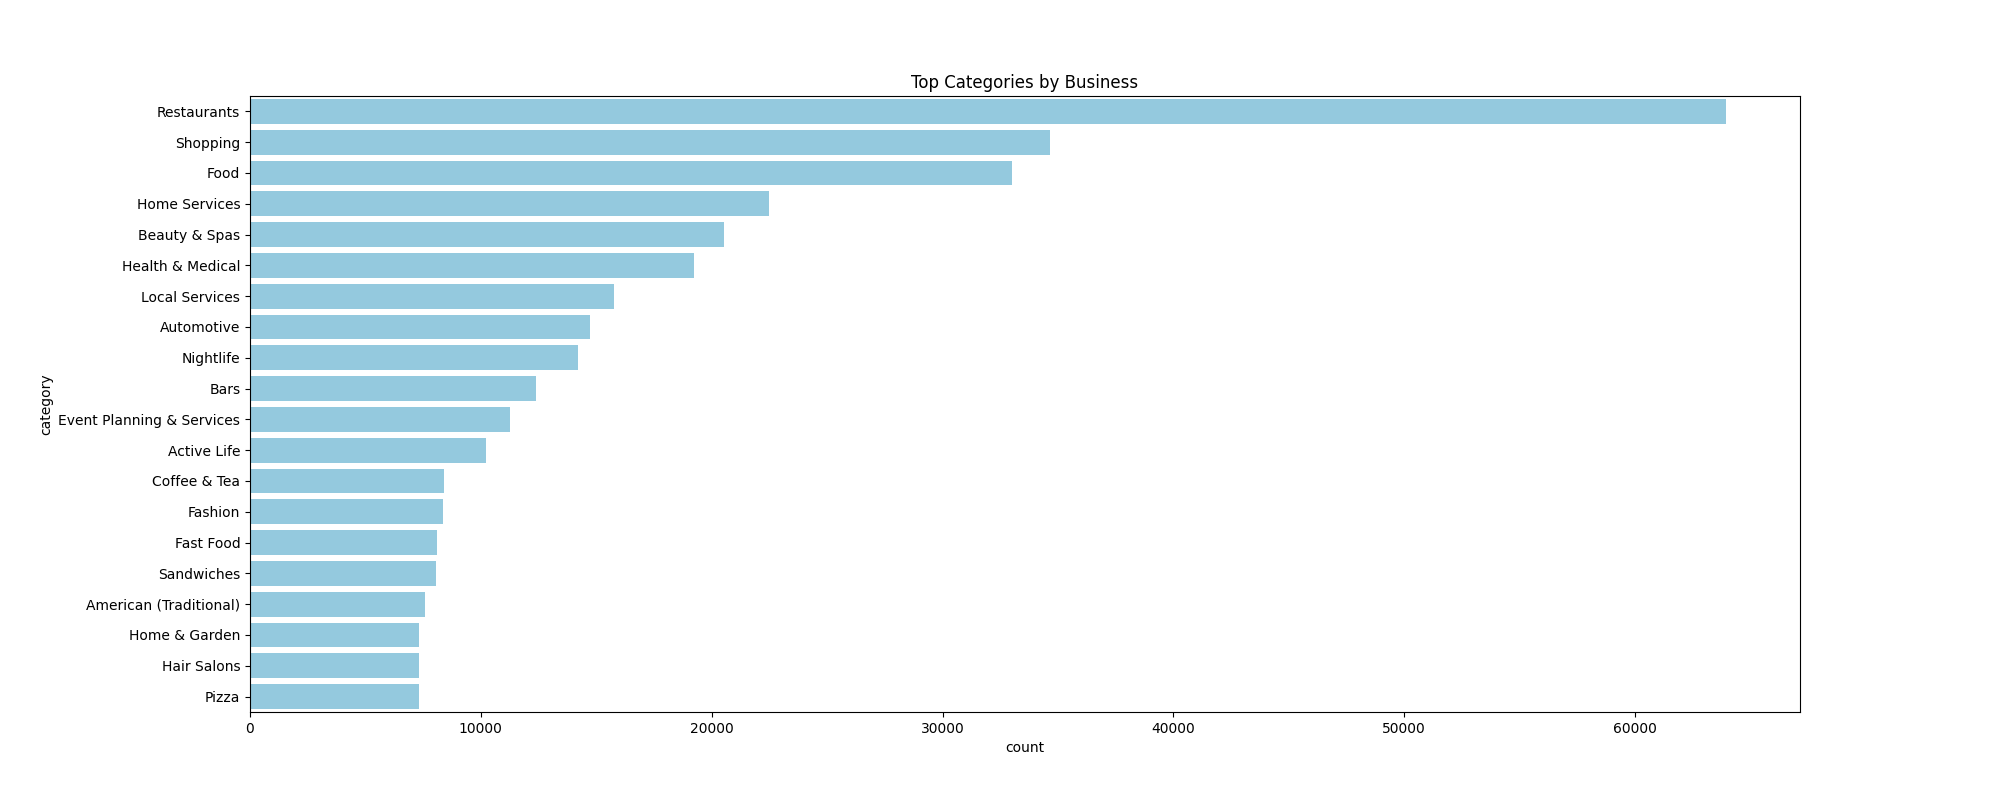

In [28]:
top_cate_df = spark.sql("select category, count(*) as count from categories group by category order by count(*) desc limit 20")

top_cate_df2 = top_cate_df.toPandas()

fig, ax = plt.subplots(figsize = (20,8))
top_cate_plot = seaborn.barplot(x = 'count', y = 'category', data = top_cate_df2, ax = ax, color = 'skyblue')
ax.set_title('Top Categories by Business')
%matplot plt

# Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are extremely _dissatisfied_ or extremely _satisfied_ with the service received. 

How true is this really? Let's try and answer this question.

## Loading User Data

Begin by loading the review data set from S3 and printing schema to determine what data is available.

In [29]:
df2 = spark.read.json('s3://yelp-dataset-jack/yelp_academic_dataset_review.json')
df2.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the `business_id` and `stars` columns together for the user reviews data.

In [31]:
df2.createOrReplaceTempView("review")
output = spark.sql('select business_id, stars from review limit 5')
output.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+

Now, let's aggregate along the `stars` column to get a resultant dataframe that displays _average stars_ per business as accumulated by users who **took the time to submit a written review**.

In [37]:
output = spark.sql('select business_id, avg(stars) as avgStars from review group by business_id')
output.createOrReplaceTempView("averageReview")
output1 = spark.sql('select * from averageReview limit 5')
output1.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|          avgStars|
+--------------------+------------------+
|ATeOjZzE3VOI-RW7F...| 3.433734939759036|
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|vbUABNAQI2iwN7v0x...|2.4545454545454546|
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|r-W1HPIZ3V6S2DaXh...| 4.852459016393443|
+--------------------+------------------+

Now the fun part - let's join our two dataframes (reviews and business data) by `business_id`. 

In [61]:
output = spark.sql('''select rev.*, bus.stars, bus.name, bus.city, bus.state 
                        from business as bus 
                        left outer join averageReview as rev 
                        on bus.business_id = rev.business_id''')
output.createOrReplaceTempView("joinedOutput")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's see a few of these:

In [39]:
output = spark.sql("select avgStars, stars, name, city, state from joinedOutput limit 5")
output.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+-----------------+-----+
|          avgStars|stars|                name|             city|state|
+------------------+-----+--------------------+-----------------+-----+
|               5.0|  5.0|      Bachelor Vegas|        Las Vegas|   NV|
| 4.029411764705882|  4.0|Bonga Korean Rest...|          Calgary|   AB|
| 3.380952380952381|  3.5|Cracker Barrel Ol...|Sheffield Village|   OH|
| 4.760869565217392|  5.0|Xpand Realty & Pr...|        Las Vegas|   NV|
|1.7272727272727273|  1.5|  Buffalo Bill Wings|         Montréal|   QC|
+------------------+-----+--------------------+-----------------+-----+

Compute a new dataframe that calculates what we will call the _skew_ (for lack of a better word) between the avg stars accumulated from written reviews and the _actual_ star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [42]:
skew_df = spark.sql("select (avgStars-stars)/stars from joinedOutput")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

And finally, graph it!

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

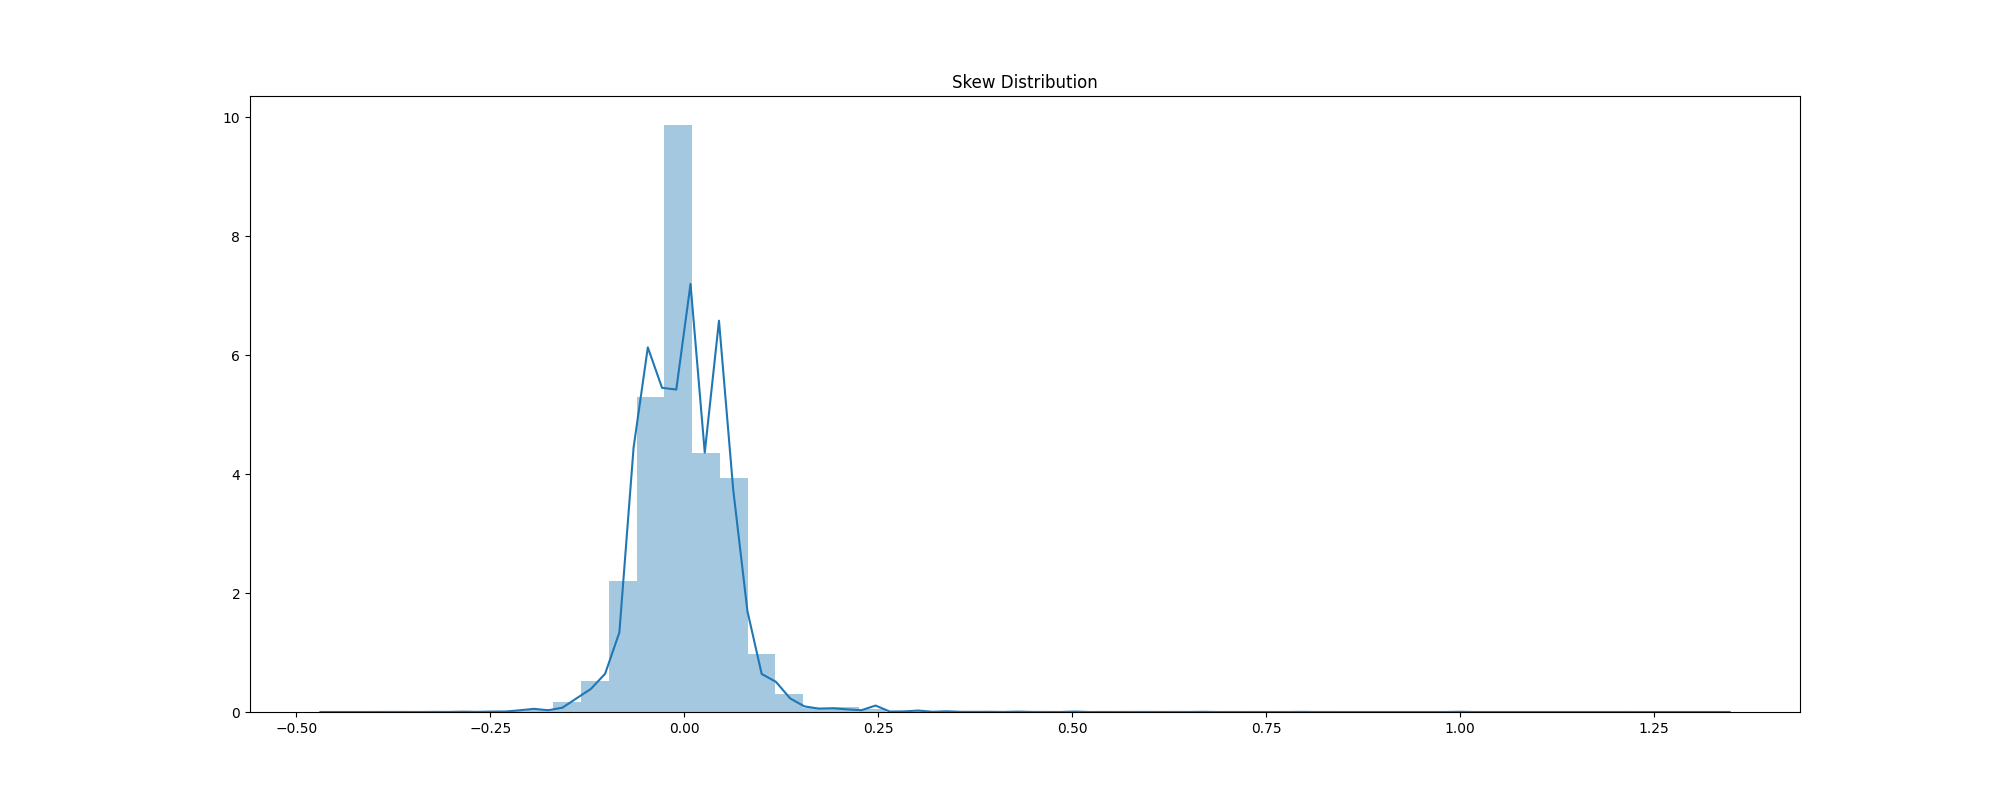

In [55]:
skew_df_2 = skew_df.toPandas()

fig, ax = plt.subplots(figsize = (20,8))
skew_plot = seaborn.distplot(skew_df_2)
ax.set_title('Skew Distribution')
%matplot plt

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph. 

No, the skew visualization indicates a positive skew, so we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. 

# Do users with more funny compliments tend to be more positive? (- Analysis of your choice)

For the final portion - you have a choice:

* Try and analyze some interesting dimension to this data. The **ONLY** requirement is that you must use the **Users** dataset and join on either the **business* or **reviews** dataset

Feel free to use any and all methodologies at your disposal - only requirement is you must render one visualization in your analysis

Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [44]:
df3 = spark.read.json('s3://yelp-dataset-jack/yelp_academic_dataset_user.json')
df3.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

In [46]:
df3.createOrReplaceTempView("user")
output = spark.sql('select name, user_id, review_count from user limit 5')
output.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+------------+
|   name|             user_id|review_count|
+-------+--------------------+------------+
|   Tony|7fOIDwj7xovQ6igNg...|           5|
|  Lydia|z8V2oPYZLUTLXB0UU...|          51|
|  Shane|Rj14umKuoJwBE2GS1...|         210|
|Shannon|TD4cJafak4HMZNLnQ...|          32|
|   John|m_7E3dV1W79Cj7WvM...|         109|
+-------+--------------------+------------+

Now the fun part - let's join the three dataframes (reviews, uses, and business data) by business_id and user_id.

In [52]:
output = spark.sql('''select u.user_id, r.stars as starsU, u.compliment_funny, b.business_id, b.stars as starsB
                        from user u 
                        inner join review r
                            on r.user_id = u.user_id
                        inner join business b
                            on r.business_id = b.business_id''')
output.createOrReplaceTempView("joinedOutput2")
output = spark.sql('select * from joinedOutput2 limit 5')
output.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------+----------------+--------------------+------+
|             user_id|starsU|compliment_funny|         business_id|starsB|
+--------------------+------+----------------+--------------------+------+
|-0Ji0nOyFe-4yo8BK...|   4.0|               1|pmrHuQiy25xKB86tb...|   4.0|
|-0XPr1ilUAfp-yIXZ...|   2.0|               0|QhwaGi1niDeVEHMRt...|   2.5|
|-1KKYzibGPyUX-Mwk...|   4.0|               2|L772e6l2Yd0DJEyCB...|   3.0|
|-1zQA2f_syMAdA04P...|   5.0|               0|aNe8ofTYrealxqv7V...|   3.5|
|-1zQA2f_syMAdA04P...|   1.0|               0|5c-b0ALS_DyLvRCGr...|   2.5|
+--------------------+------+----------------+--------------------+------+

Now we separate the users into two groups based on the average number of funny compliments to calculate the skew

In [93]:
df_user_f1 = spark.sql('''select (starsU-starsB)/starsB as skew 
                            from joinedOutput2
                            where compliment_funny < (select avg(compliment_funny) from joinedOutput2)''')

df_user_f2 = spark.sql('''select (starsU-starsB)/starsB as skew 
                            from joinedOutput2
                            where compliment_funny > (select avg(compliment_funny) from joinedOutput2)''')


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Skew of Lower No. Funny Compliments

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

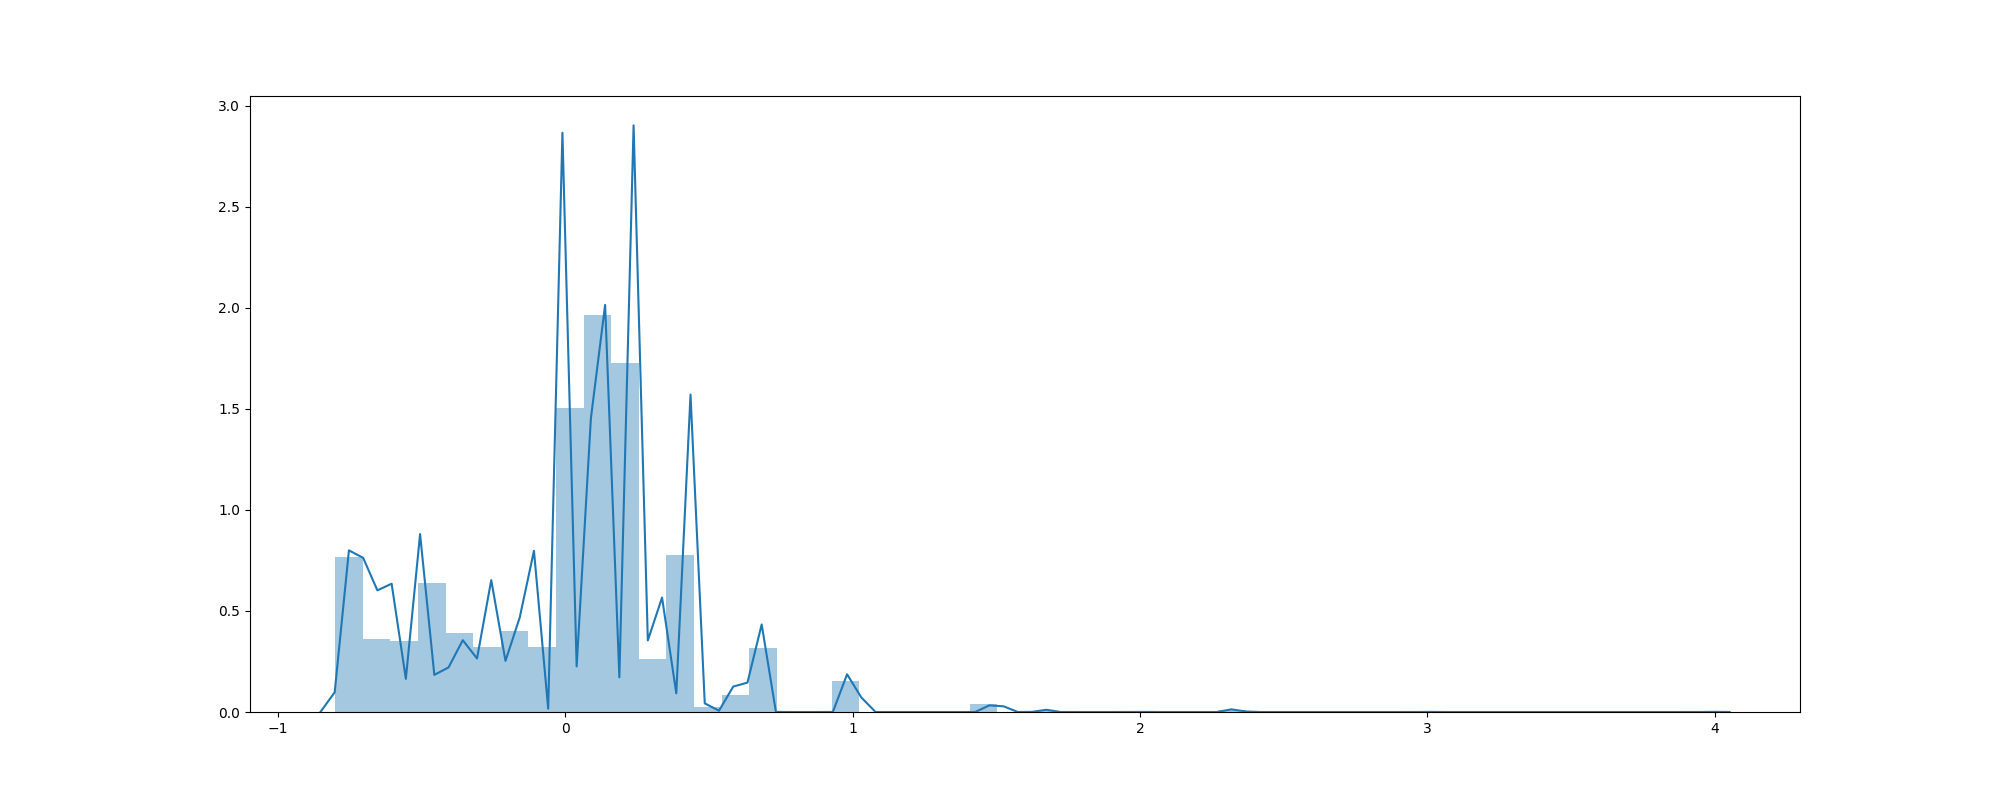

In [89]:
df_user_f1 = df_user_f1.toPandas()
fig, axes = plt.subplots(1, 1, figsize=(20, 8), sharex=True)
skew_plot1 = seaborn.distplot(df_user_f1)
%matplot plt

Skew of Higher No. Funny Compliments

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

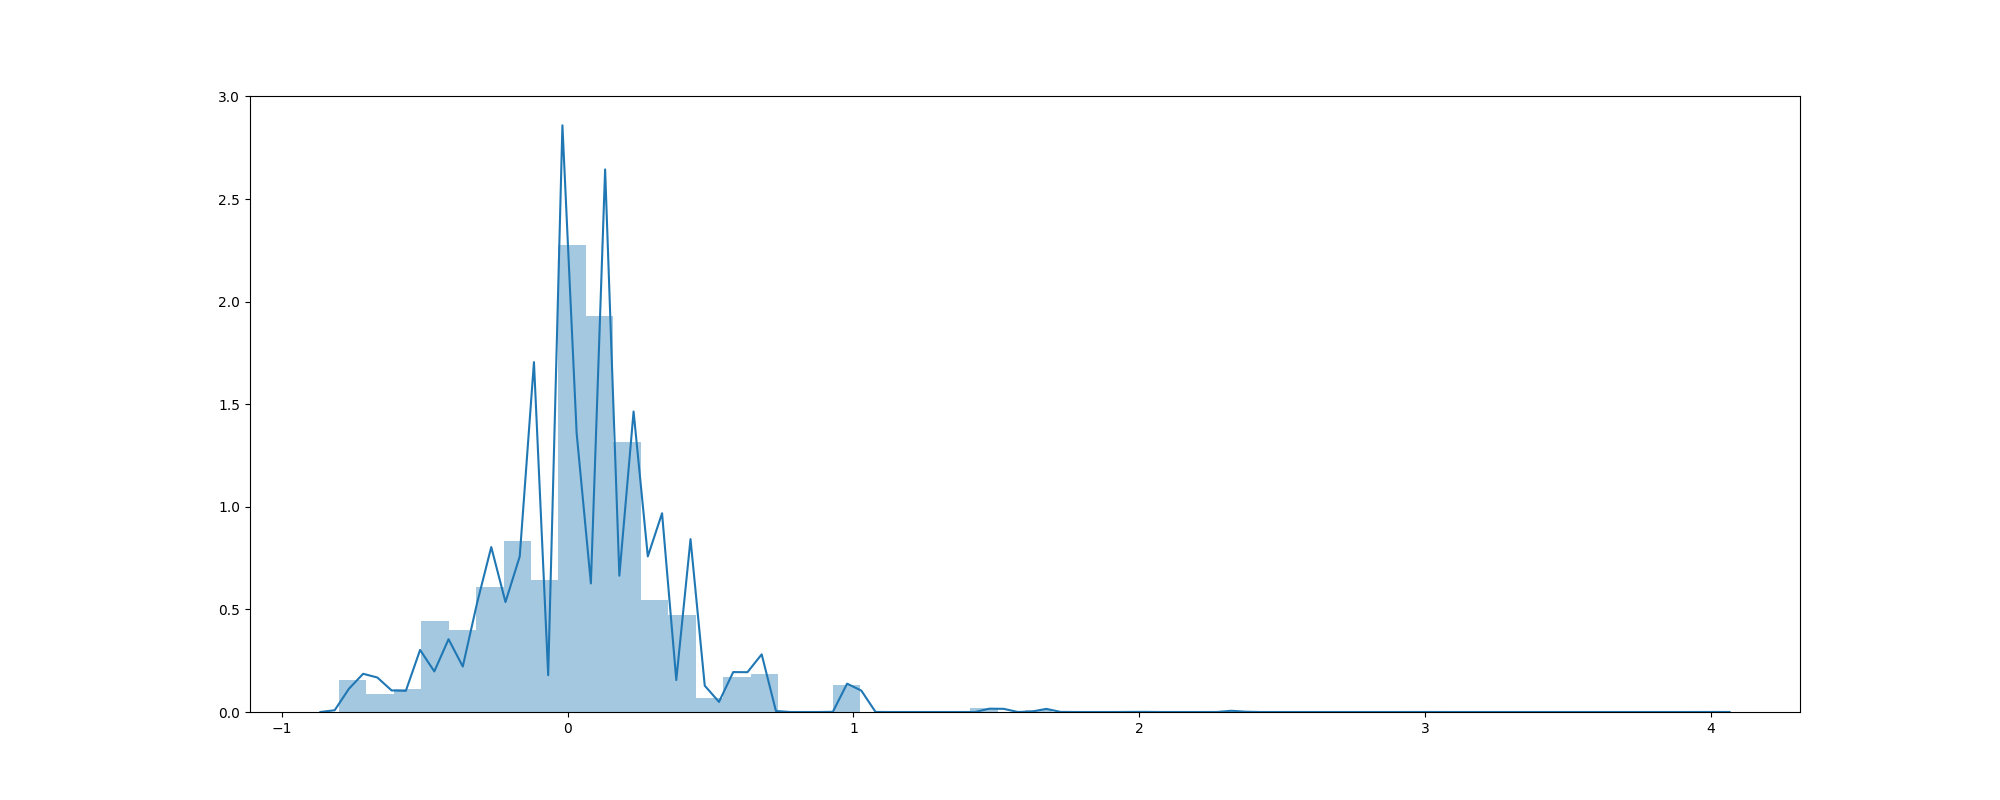

In [94]:
df_user_f2 = df_user_f2.toPandas()
fig, axes = plt.subplots(1, 1, figsize=(20, 8), sharex=True)
skew_plot2 = seaborn.distplot(df_user_f2)
%matplot plt

By looking at the first skew distribution chart, which displays the skew of users with lower numbers of funny compliments, we see that the skew is positive. And, the second skew distribution chart, which displays the skew of users with higher numbers of funny compliments, shows that the skew is also positive but is more postive than the users whose numbers of funny compliments are lower. 

Copy Right Jack Yang 2020